In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [3]:
# x, y, z represent the axis in the simulation space. 
x = np.linspace(-7.5e-6, 7.5e-6, 1000)
y = np.linspace(-7.5e-6, 7.5e-6, 1000)
z = np.linspace(-0.1e-6, 0.1e-6, 100)

# We can calculate the convolution on much a larger XY space then the simulation
# output_x, output_y are the axis for the phase calculated on the larger space.
output_x = np.linspace(-20e-6, 20e-6, 500)
output_y = np.linspace(-20e-6, 20e-6, 500)

In [4]:
with open('phase_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['light_on', 'light_off', 'phase_diff'])

In [5]:
light_off_phase = data['light_off']
light_on_phase = data['light_on']
phase_diff = data['phase_diff']

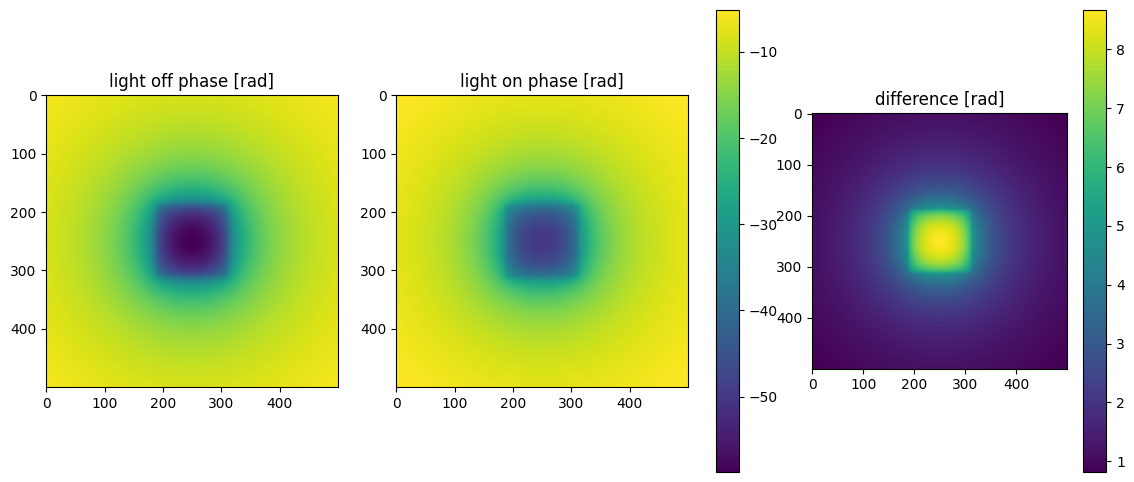

In [6]:
min_phase = np.min([light_off_phase, light_on_phase])
max_phase = np.max([light_off_phase, light_on_phase])

fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(14,6))

axes[0].set_title('light off phase [rad]')
im = axes[0].imshow(light_off_phase, vmin=min_phase, vmax=max_phase)
axes[1].set_title('light on phase [rad]')
im = axes[1].imshow(light_on_phase, vmin=min_phase, vmax=max_phase)

plt.colorbar(im, ax=axes[:2], fraction=0.046, pad=0.04)

axes[2].set_title('difference [rad]')
im = axes[2].imshow(phase_diff)
plt.colorbar(im, ax=axes[2]) #, fraction=0.046, pad=0.04)


In [7]:
# We use abtem to calculate the fringes.
import abtem

def get_defoc_image(phase, defocus_distance_angs=5e8):
    wave = abtem.Waves(np.exp(1j * phase), energy=200e3, extent=[x.min()/1e-10, x.max()/1e-10])
    wave.compute()
    
    fres = abtem.multislice.FresnelPropagator()

    output = fres.propagate(waves=wave, thickness=defocus_distance_angs)
    output.compute()

    probs = np.abs(output.array)
    probs /= np.sum(probs)
    
    return probs

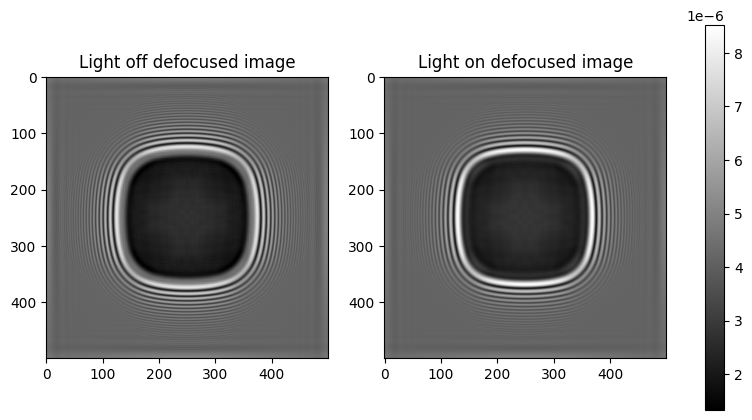

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

light_off_image = get_defoc_image(light_off_phase)
light_on_image = get_defoc_image(light_on_phase)

min_val = np.min([light_off_image, light_on_image])
max_val = np.max([light_off_image, light_on_image])

axes[0].set_title('Light off defocused image')
im = axes[0].imshow(light_off_image, cmap='gray', vmin=min_val, vmax=max_val)

axes[1].set_title('Light on defocused image')
im = axes[1].imshow(light_on_image, cmap='gray', vmin=min_val, vmax=max_val)

plt.colorbar(im, ax=axes)

Text(0, 0.5, 'Measurement probabilities')

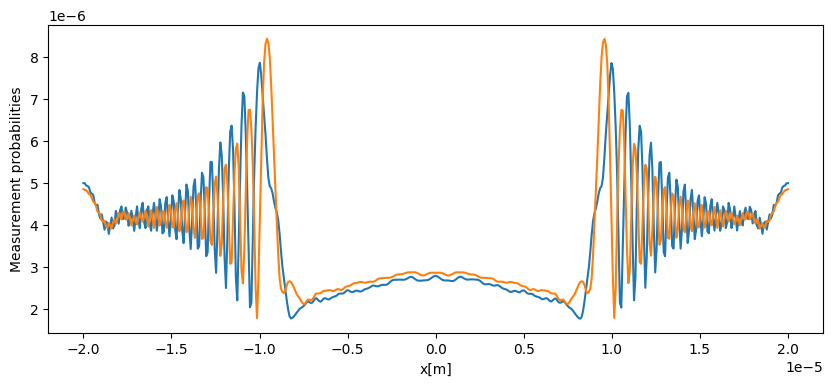

In [10]:
plt.figure(figsize=(10,4))
plt.plot(output_x, light_off_image[250,:], label='light_off')
plt.plot(output_x, light_on_image[250,:], label='light_on')
plt.xlabel('x[m]')
plt.ylabel('Measurement probabilities')

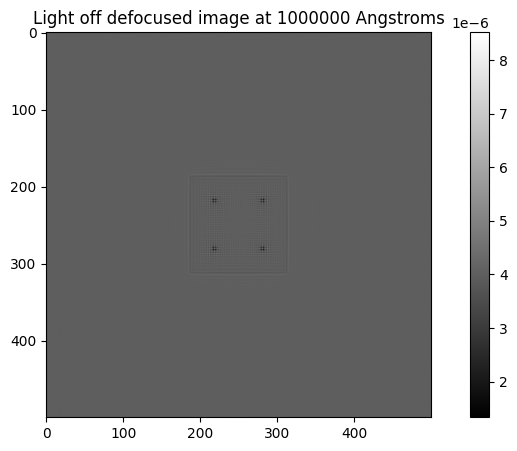

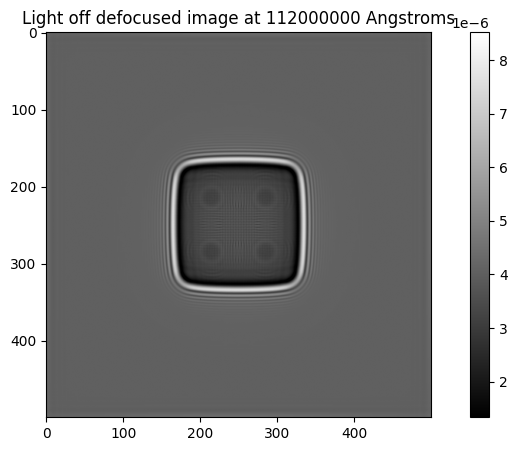

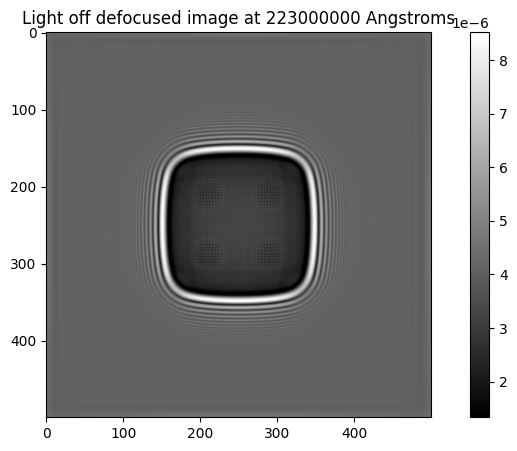

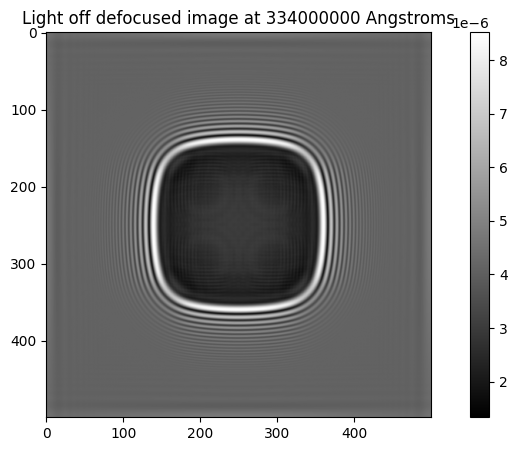

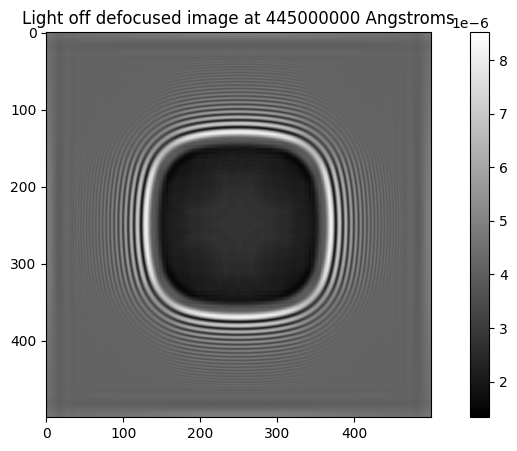

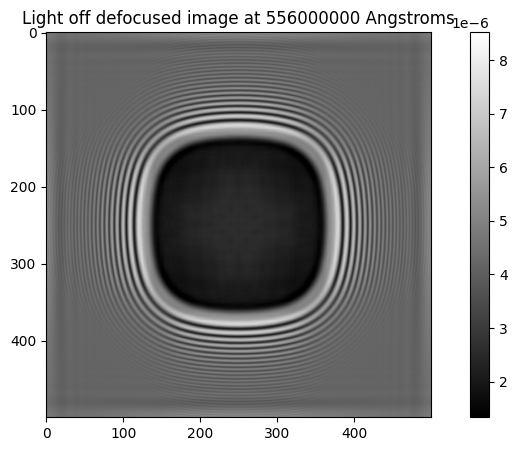

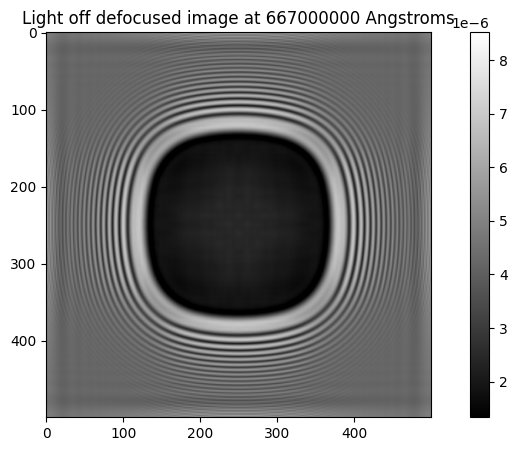

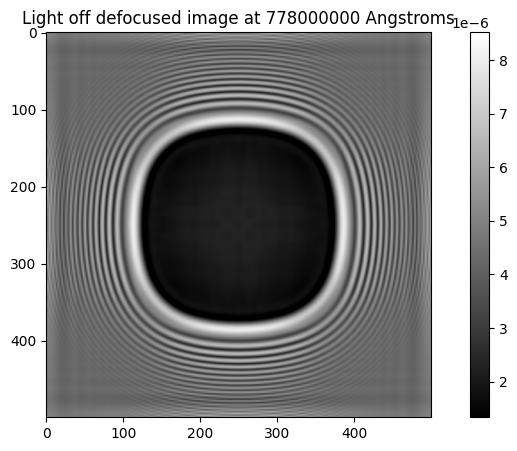

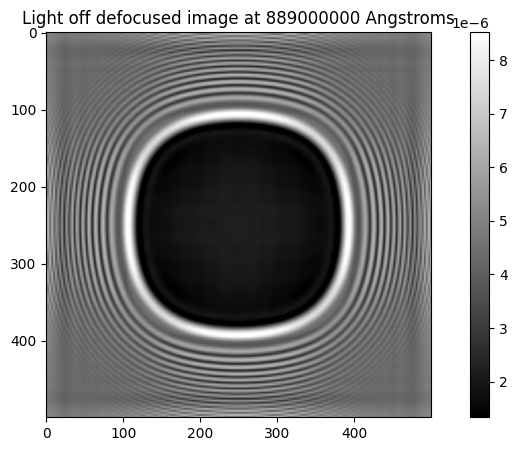

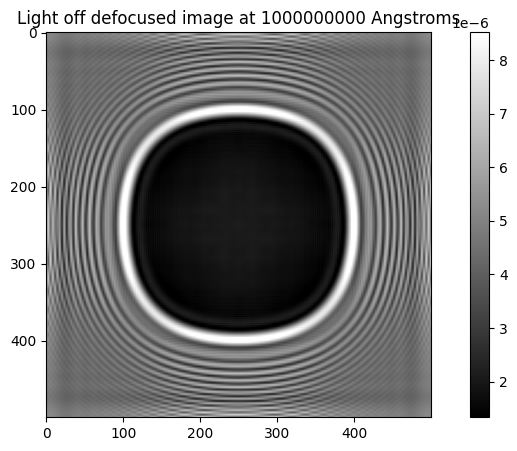

In [11]:
# create files with defocused images from 1e6 to 1e9
defocus_distances = np.linspace(1e6, 1e9, 10)
for defocus_distance in defocus_distances:
    light_off_image = get_defoc_image(light_off_phase, defocus_distance_angs=defocus_distance)
    light_on_image = get_defoc_image(light_on_phase, defocus_distance_angs=defocus_distance)

    # save as png
    plt.figure(figsize=(10,5))
    plt.imshow(light_off_image, cmap='gray', vmin=min_val, vmax=max_val)
    plt.title(f'Light off defocused image at {defocus_distance:.0f} Angstroms')
    plt.colorbar()
    plt.savefig(f'light_off_defocused_{int(defocus_distance)}.png')